### Data Understanding

In [15]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd

%matplotlib inline

Helper function that takes in the name of the table, and return a dataframe with the data

In [16]:
def read_csv(filename: str):
    return pd.read_csv("dados/pre-preocessed/" + filename + ".csv", sep=",")

Helper function that takes in a table and checks how many account ids are repeated

In [120]:
def check_repeated(df: pd.DataFrame, table_name: str):
    count = df['account_id'].value_counts().values
    repeated = [i for i in count if i >= 2]
    print("Number of repeated account id values in " + table_name + ": " + str(len(repeated)))

In [72]:
loans = read_csv("loan_dev")

### Loans

Start by reading the csv to a dataframe. Display first rows to assess the kind of data we're working with

In [41]:
loans = read_csv("loan_dev")
loans.head()

,loan_id,account_id,amount,duration,payments,status,loan_date,loan_year,loan_month,loan_day
0,4959,2,80952,24,3373,1,1994-01-05,1994,1,5
1,4961,19,30276,12,2523,-1,1996-04-29,1996,4,29
2,4973,67,165960,24,6915,1,1996-05-02,1996,5,2
3,4996,132,88440,12,7370,1,1996-11-06,1996,11,6
4,5002,173,104808,12,8734,1,1994-05-31,1994,5,31


Let's check for repeated rows. There can be two loans per account, however, there should not be any rows with the same loan_id

In [18]:
duplicated_loan = loans.loan_id.duplicated().any() if loans.loan_id.duplicated().any() else 0
loans_per_acc   = loans.account_id.duplicated().any() if loans.account_id.duplicated().any() else 0

print ("There are", duplicated_loan, "duplicated loans")
print ("Number of account with more than one loan:", loans_per_acc)

There are 0 duplicated loans
Number of account with more than one loan: 0


#### Heatmap

Find correlation between attributes using a heatmap

<AxesSubplot:>

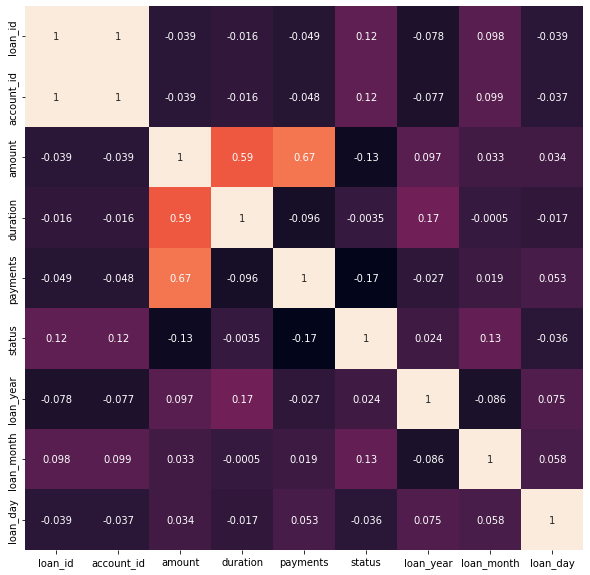

In [19]:
plt.figure(figsize=(10, 10))
sns.heatmap(loans.corr(), annot=True, cbar=False)

Status is inversely proportional to payments and amount, which is also expected, as the bigger the loan, the harder it is to pay it.
As per observation of the heatmap above, we see that payments, duration and amount of loan are correlated, as per expected.

#### Variable distribution

So let's analyse the distribution of values for amount and payments with two histograms.

<AxesSubplot:xlabel='payments', ylabel='Count'>

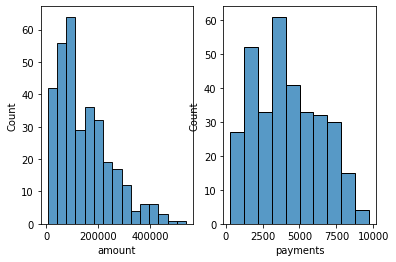

In [22]:
fig, ax = plt.subplots(1,2)

# Create the graphics
sns.histplot(data=loans, x='amount', ax=ax[0])
sns.histplot(data=loans, x='payments', ax=ax[1])

We can also see the valid values for duration.

In [35]:
print("Loan Durations", loans.duration.unique().tolist())

Loan Durations [24, 12, 48, 60, 36]


As we can see above, these correspond to years, so let's convert them

<AxesSubplot:xlabel='duration', ylabel='Count'>

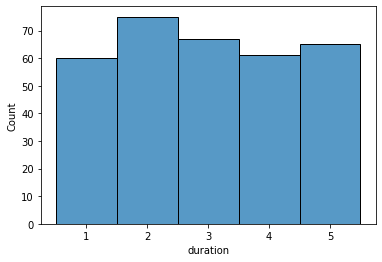

In [45]:
loans.duration = (loans.duration / 12).astype('int')
sns.histplot(data=loans, x='duration', discrete=True)

No issues, looks balanced

### Dispostion

In [46]:
disp = read_csv("disp")
disp.head()

,disp_id,client_id,account_id,type
0,1,1,1,owner
1,2,2,2,owner
2,3,3,2,disponent
3,4,4,3,owner
4,5,5,3,disponent


As per the discription of the table, the tuple (client_id, disp_id) should be unique. However, one account might have one or more client_ids

We will check for repetead values in all columns mentionted above

In [121]:
print("Duplicates in disp_id:\t\t%d" %disp['disp_id'].duplicated().any())
print("Duplicates in client_id:\t%d" %disp['client_id'].duplicated().any())
check_repeated(disp, "dispostion")

owner = disp['type'].str.count("owner")
print("Owner:   ", owner.sum())
print("Disponent:", owner.count() - owner.sum())


Duplicates in disp_id:		0
Duplicates in client_id:	0
Number of repeated account id values in dispostion: 869
Owner:    4500
Disponent: 869


There are no repeated client_id or account_id so there's no issues yet. The rest makes sense as there are 869 clients who are the disponent of an account and, there are exactly 869 repeated account ids

#### Heatmap

Let's merge dispostion and loan so that we can better assess correlation between varibales 

In [73]:
loans_ = loans[['account_id', 'status']]
loans_disp= loans_.merge(right=disp, how='inner', on='account_id')
print(loans_disp.head())

   account_id  status  disp_id  client_id       type
0           2       1        2          2      owner
1           2       1        3          3  disponent
2          19      -1       25         25      owner
3          67       1       78         78      owner
4         132       1      158        158      owner


To use the type in the heatmap, we need to convert it to a numerical value

In [74]:
loans_disp["type"].replace(["owner", "disponent"], [0, 1], inplace =True)
print(loans_disp.tail())

     account_id  status  disp_id  client_id  type
398       11265       1    13537      13845     0
399       11349       1    13647      13955     0
400       11349       1    13648      13956     1
401       11359       1    13660      13968     0
402       11362       1    13663      13971     0


<AxesSubplot:>

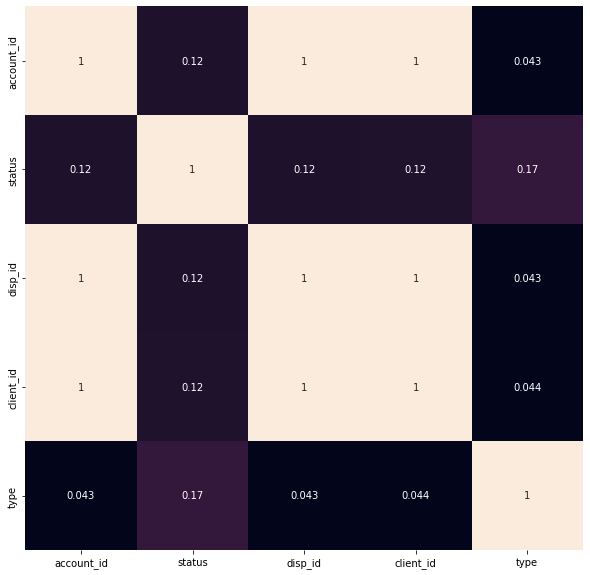

In [75]:
plt.figure(figsize=(10, 10))
sns.heatmap(loans_disp.corr(), annot=True, cbar=False)

### Account

In [71]:
accounts = read_csv('account')
accounts.head()

,account_id,district_id,frequency,acc_creation_date,acc_creation_year,acc_creation_month,acc_creation_day
0,1,18,monthly issuance,1995-03-24,1995,3,24
1,2,1,monthly issuance,1993-02-26,1993,2,26
2,3,5,monthly issuance,1997-07-07,1997,7,7
3,4,12,monthly issuance,1996-02-21,1996,2,21
4,5,15,monthly issuance,1997-05-30,1997,5,30


Merge with the loans dataset

In [77]:
loan_accounts = pd.merge(loans, accounts, how="left", on=["account_id"])
loan_accounts.head()

,loan_id,account_id,amount,duration,payments,status,loan_date,loan_year,loan_month,loan_day,district_id,frequency,acc_creation_date,acc_creation_year,acc_creation_month,acc_creation_day
0,4959,2,80952,24,3373,1,1994-01-05,1994,1,5,1,monthly issuance,1993-02-26,1993,2,26
1,4961,19,30276,12,2523,-1,1996-04-29,1996,4,29,21,monthly issuance,1995-04-07,1995,4,7
2,4973,67,165960,24,6915,1,1996-05-02,1996,5,2,16,monthly issuance,1994-10-19,1994,10,19
3,4996,132,88440,12,7370,1,1996-11-06,1996,11,6,40,issuance after transaction,1996-05-11,1996,5,11
4,5002,173,104808,12,8734,1,1994-05-31,1994,5,31,66,monthly issuance,1993-11-26,1993,11,26


We can also create new variables to better visualise the data, as the account age that is the subtraction of the year of the loan and the year of the creation of the account

In [82]:
loan_accounts["acc_age"] = loan_accounts.loan_year - loan_accounts.acc_creation_year

#### Heatmap

<AxesSubplot:>

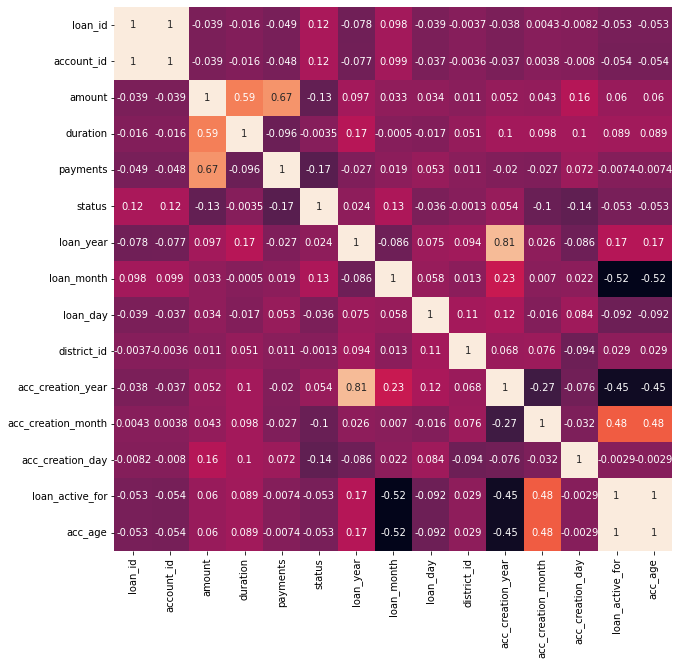

In [83]:
plt.figure(figsize=(10, 10))
sns.heatmap(loan_accounts.corr(), annot=True, cbar=False)

We can observe a correlation between acc_creation_year and loan_year, let's dive further

<AxesSubplot:xlabel='acc_age', ylabel='Count'>

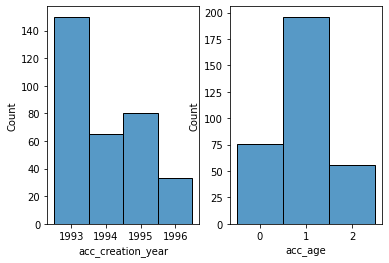

In [84]:
fig, ax = plt.subplots(1,2)

# Create the graphics
sns.histplot(data=loan_accounts, x='acc_creation_year', discrete=True, ax=ax[0])
sns.histplot(data=loan_accounts, x='acc_age', discrete=True, ax=ax[1])

### Card

In [86]:
cards = read_csv('card_dev')
cards.tail()

,card_id,disp_id,type,card_issued_date,card_issued_year,card_issued_month,card_issued_day
172,1164,12269,classic,1996-08-12,1996,8,12
173,1176,12502,gold,1996-07-03,1996,7,3
174,1187,12635,gold,1996-07-17,1996,7,17
175,1225,13268,classic,1995-11-22,1995,11,22
176,1247,13660,classic,1995-06-13,1995,6,13


Merge card table with dispotion and loan to check for variable correlation

In [87]:
## Read disposition
disps = read_csv('disp')

## Merge card df with disposition
card_disps = pd.merge(cards, disps, how="left", on="disp_id")

## Merge the new df with loans
loan_cards = pd.merge(loans, card_disps, how="inner", on="account_id")

loan_cards.head()

,loan_id,account_id,amount,duration,payments,status,loan_date,loan_year,loan_month,loan_day,card_id,disp_id,type_x,card_issued_date,card_issued_year,card_issued_month,card_issued_day,client_id,type_y
0,5088,544,91152,24,3798,1,1996-08-22,1996,8,22,119,655,classic,1996-08-08,1996,8,8,655,owner
1,5311,1766,30060,60,501,1,1996-06-15,1996,6,15,337,2141,classic,1996-01-01,1996,1,1,2141,owner
2,5595,3050,82896,12,6908,1,1994-09-02,1994,9,2,577,3687,classic,1994-02-15,1994,2,15,3687,owner
3,5900,4503,135360,48,2820,1,1996-01-01,1996,1,1,783,5433,junior,1995-10-24,1995,10,24,5433,owner
4,6550,7614,320592,48,6679,1,1996-05-18,1996,5,18,989,9119,classic,1996-02-21,1996,2,21,9427,owner


#### Heatmap

<AxesSubplot:>

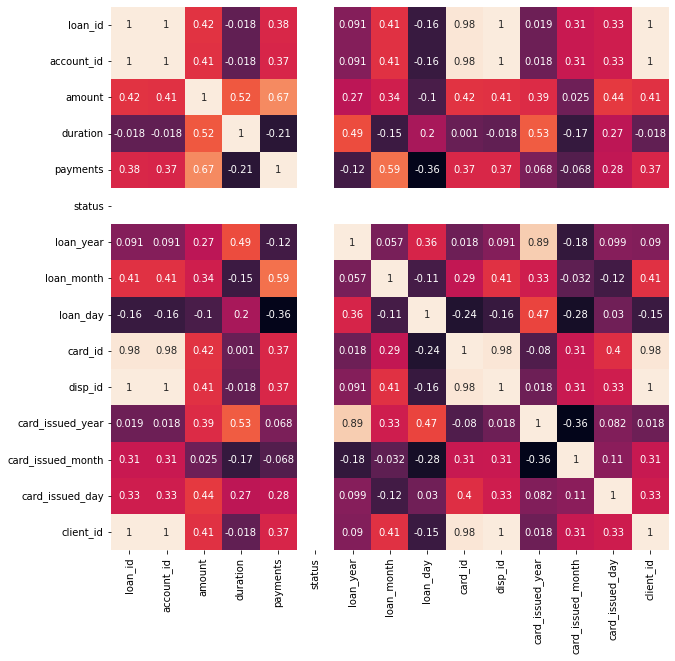

In [88]:
plt.figure(figsize=(10, 10))
sns.heatmap(loan_cards.corr(), annot=True, cbar=False)

### Client

In [96]:
def check_invalid_year(years: list):
    valid = range(1900, 2000)
    invalid = 0
    for year in years:
        if year not in valid:
            invalid = invalid + 1
    
    return invalid

In [100]:
def check_invalid_month(months: list):
    valid = range(1, 13)
    invalid = 0
    for month in months:
        if month not in valid:
            invalid = invalid + 1
    
    return invalid

In [98]:
def check_invalid_day(days: list):
    valid = range(1, 32)
    invalid = 0
    for day in days:
        if day not in valid:
            invalid = invalid + 1
    
    return invalid

In [91]:
client = read_csv("client")
client.tail()

,client_id,district_id,birthdate,birthdate_year,birthdate_month,birthdate_day,sex
5364,13955,1,1945-60-30,1945,10,30,f
5365,13956,1,1943-04-06,1943,4,6,m
5366,13968,61,1968-04-13,1968,4,13,m
5367,13971,67,1962-60-19,1962,10,19,f
5368,13998,74,1953-58-12,1953,8,12,f


Check for invalid dates

In [101]:
invalid_years = check_invalid_year(list(client.birthdate_year))
print("Invalid years -> ", invalid_years)

invalid_months = check_invalid_month(list(client.birthdate_month))
print("Invalid months -> ", invalid_months)

invalid_days = check_invalid_day(list(client.birthdate_day))
print("Invalid days -> ", invalid_days)


Invalid years ->  0
Invalid months ->  0
Invalid days ->  0


Let's check for gender inbalance

In [102]:
print(client.sex.value_counts())

m    2724
f    2645
Name: sex, dtype: int64


Looks pretty balanced, nothing to worry about

Let's now merge the client table with the loan table

In [124]:
client_loan = disp.merge(right = loans, how = "inner", on="account_id")
client_loan.head()

,disp_id,client_id,account_id,type,loan_id,amount,duration,payments,status,loan_date,loan_year,loan_month,loan_day
0,2,2,2,owner,4959,80952,24,3373,1,1994-01-05,1994,1,5
1,3,3,2,disponent,4959,80952,24,3373,1,1994-01-05,1994,1,5
2,25,25,19,owner,4961,30276,12,2523,-1,1996-04-29,1996,4,29
3,78,78,67,owner,4973,165960,24,6915,1,1996-05-02,1996,5,2
4,158,158,132,owner,4996,88440,12,7370,1,1996-11-06,1996,11,6


In [125]:
check_repeated(client_loan, "loan merged with client")

Number of repeated account id values in loan merged with client: 75


There are 75 loans that have been taken by accounts that are used by 2 clients

#### Could people that share an account have be a better change at paying the loan since their household income would possibly be higher that those that are alone in an account?

In [135]:
## Get repeated loan ids
repeated = client_loan.groupby("loan_id").count()['disp_id'].sort_index()

## Export it to a dataframe
repeated_df = pd.DataFrame({"loan_id": repeated.index, "count": repeated.values})

## Get the status of the loans
status = client_loan[['loan_id', 'status']]

## Merge with the repeated dataframe using a inner join on loan_id
count_clients = repeated_df.merge(right=status, on="loan_id", how="inner")

## Remove duplicated values
count_clients.drop_duplicates(subset=['loan_id'])

,loan_id,count,status
0,4959,2,1
2,4961,1,-1
3,4973,1,1
4,4996,2,1
6,5002,2,1
...,...,...,...
396,7271,2,1
398,7284,1,1
399,7304,2,1
401,7305,1,1


Check for correlation

In [139]:
count_clients[["count", "status"]].corr()

,count,status
count,1.000000,0.276395
status,0.276395,1.000000


#### Check for correlation in gender and age

Firstly, let's convert categorical sex value to numerical

In [141]:
client.replace(["m", "f"], [0, 1], inplace=True)
client.tail()

,client_id,district_id,birthdate,birthdate_year,birthdate_month,birthdate_day,sex
5364,13955,1,1945-60-30,1945,10,30,1
5365,13956,1,1943-04-06,1943,4,6,0
5366,13968,61,1968-04-13,1968,4,13,0
5367,13971,67,1962-60-19,1962,10,19,1
5368,13998,74,1953-58-12,1953,8,12,1


In [147]:
client_loan_2 = disp.merge(right = loans, how = "inner", on="account_id")
client_loan_2 = client_loan_2[['account_id', 'client_id', 'status']]
client_2 = client[['client_id', 'birthdate_year', 'sex']]
client_2

,client_id,birthdate_year,sex
0,1,1970,1
1,2,1945,0
2,3,1940,1
3,4,1956,0
4,5,1960,1
...,...,...,...
5364,13955,1945,1
5365,13956,1943,0
5366,13968,1968,0
5367,13971,1962,1


In [149]:
association = client_2.merge(right=client_loan_2, on="client_id", how="inner")
association = association[["birthdate_year", "sex", "status"]]

<AxesSubplot:>

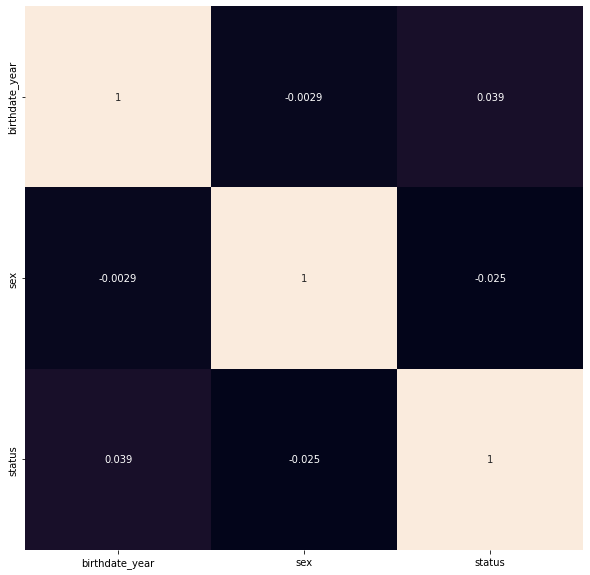

In [152]:
plt.figure(figsize=(10, 10))
sns.heatmap(association.corr(), annot=True, cbar=False)

### District

In [155]:
districts = read_csv('district')
districts.tail()

,id,city,region,num_inhab,num_municip_inhab_0_499,num_municip_inhab_500_1999,num_municip_inhab_2000_9999,num_municip_inhab_10000_,num_cities,perc_urban_inhab,avg_salary,perc_unemploy_95,perc_unemploy_96,enterp_per_1000,num_crimes_95,num_crimes_96,region_zone
72,73,Opava,Moravia,182027,17,49,12,2,7,56.4,8746.0,3.33,3.74,90,4355.0,4433,north
73,74,Ostrava,Moravia,323870,0,0,0,1,1,100.0,10673.0,4.75,5.44,100,18782.0,18347,north
74,75,Prerov,Moravia,138032,67,30,4,2,5,64.6,8819.0,5.38,5.66,99,4063.0,4505,north
75,76,Sumperk,Moravia,127369,31,32,13,2,7,51.2,8369.0,4.73,5.88,107,3736.0,2807,north
76,77,Vsetin,Moravia,148545,8,35,12,3,4,53.5,8909.0,4.01,5.56,113,3460.0,3590,north


Let's visualize correlations between attributtes using a heatmap

#### Heatmap

<AxesSubplot:>

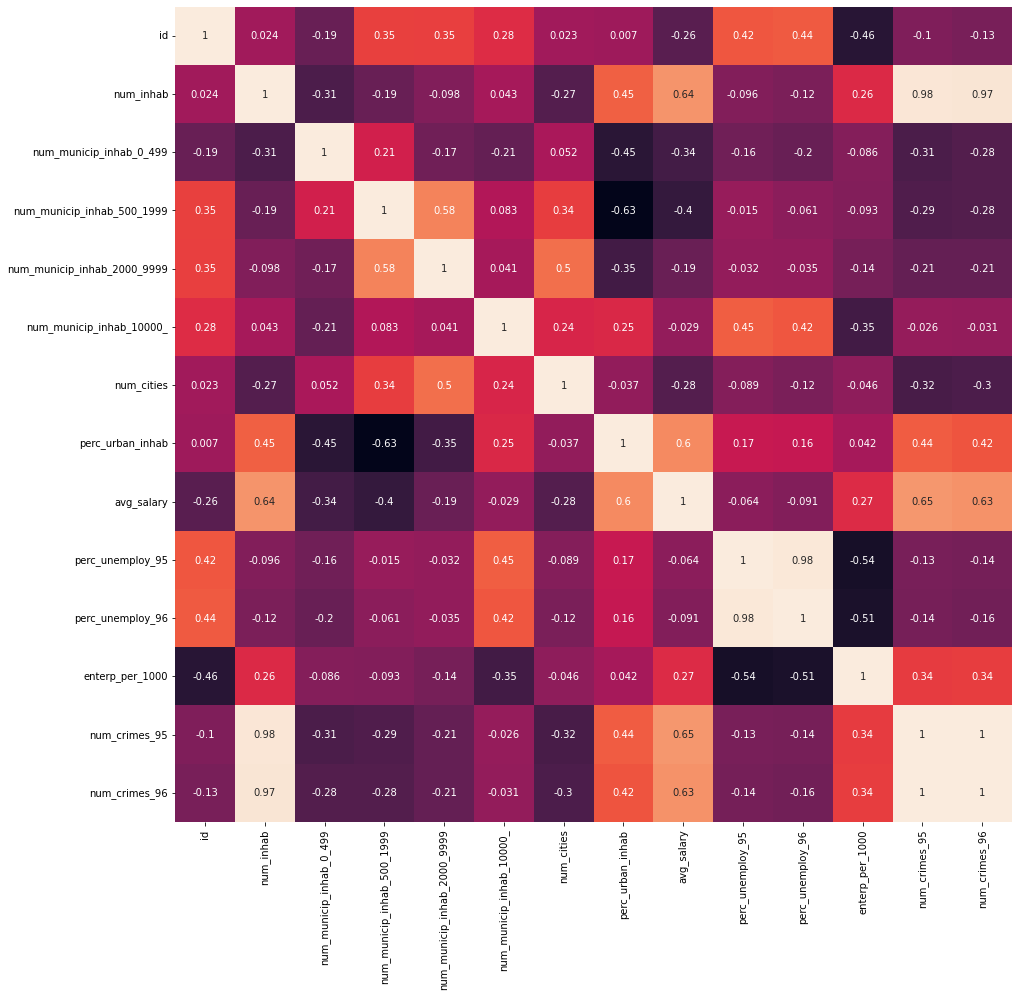

In [157]:
plt.figure(figsize=(15, 15))
sns.heatmap(districts.corr(), annot=True, cbar=False)

Some interesting but rather expected findings:
-   The higher the percentage of urban population, the higher the average salary
-   The higher the unemployment rate in any of the years, the lower the number of enterpreneurs per 100 people

Other correlations might be due to the fact that the data is not standardized

Let's plot some variables

<AxesSubplot:xlabel='num_inhab', ylabel='Count'>

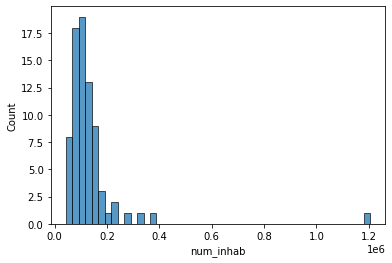

In [173]:
fig = plt.plot()
sns.histplot(data=districts, x='num_inhab')

There's a region whose number of habitatnts is way above the rest.
Let's see if we're dealing with an outlier

In [208]:
districts[districts["num_inhab"] > 1000000]

,id,city,region,num_inhab,num_municip_inhab_0_499,num_municip_inhab_500_1999,num_municip_inhab_2000_9999,num_municip_inhab_10000_,num_cities,perc_urban_inhab,avg_salary,perc_unemploy_95,perc_unemploy_96,enterp_per_1000,num_crimes_95,num_crimes_96,region_zone
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541.0,0.29,0.43,167,85677.0,99107,NaN


A simple google search can atest the verocity of the population value. Not an outlier

<AxesSubplot:xlabel='num_crimes_95', ylabel='Count'>

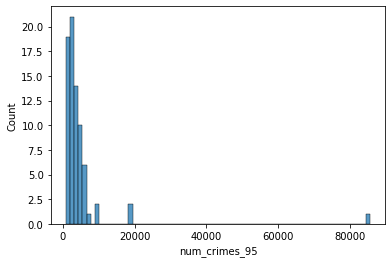

In [179]:
fig = plt.plot()
sns.histplot(data=districts, x='num_crimes_95')

Don't need to check if that's an outlier, it's just Prague. 

<AxesSubplot:xlabel='num_crimes_96', ylabel='Count'>

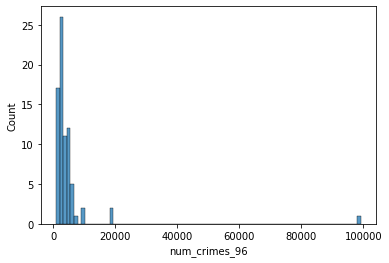

In [180]:
fig = plt.plot()
sns.histplot(data=districts, x='num_crimes_96')

Same here

#### Unemployment rate & Crimes

Let's do some exploratory analysis of this columns as they're some of the most important columns when deciding who to give a loan to (more the unemployment that crimes)

Check if there was an increase in unemployment in the two years in the dataset

In [204]:
crimes_95_mean = districts['num_crimes_95'].mean()
crimes_96_mean = districts['num_crimes_96'].mean()

unemployment_95_mean = districts['perc_unemploy_95'].mean()
unemployment_96_mean = districts['perc_unemploy_96'].mean()

print("\t1995")
print("Crimes: ", crimes_95_mean)
print("Unemployment: ", unemployment_95_mean)

print("\t1996")
print("Crimes: ", crimes_96_mean)
print("Unemployment: ", unemployment_96_mean)

print("\n")

print(f"Crime percentage increase: {round((crimes_96_mean - crimes_95_mean)/crimes_95_mean*100, 2)}%")
print(f"Unemploymnet percentage increase: {round(unemployment_96_mean - unemployment_95_mean,2)}%")

	1995
Crimes:  4850.315789473684
Unemployment:  3.119342105263158
	1996
Crimes:  5030.831168831169
Unemployment:  3.787012987012987


Crime percentage increase: 3.72%
Unemploymnet percentage increase: 0.67%


Let's now take a look into the regions

In [209]:
districts["region"].unique()

array(['Prague', 'Bohemia', 'Moravia'], dtype=object)

Only three regions in the dataset, let's take a look into each one

In [210]:
prague = districts[districts['region'] == 'Prague']
bohemia = districts[districts['region'] == 'Bohemia']
moravia = districts[districts['region'] == 'Moravia']

Compare salaries in all

In [215]:
print(f"Average salary in Prague:  {round(prague['avg_salary'].mean(), 2)}€")
print(f"Average salary in Bohemia: {round(bohemia['avg_salary'].mean(), 2)}€")
print(f"Average salary in Moravia: {round(moravia['avg_salary'].mean(), 2)}€")

Average salary in Prague:  12541.0€
Average salary in Bohemia: 9042.31€
Average salary in Moravia: 8869.6€


Prague is the richest region, which is to be expected since it's the capital of the country

#### Prague

In [220]:
print(f"Crimes per inhab: {prague['num_crimes_96'].mean() / prague['num_inhab'].mean()}") 
print(f"Unemployment rate: {prague['perc_unemploy_96'].mean()}")
print(f"Percentage of people living in urban areas: {prague['perc_urban_inhab'].mean()}")
print(f"Number of enterpreneurs per 1000 people: {prague['enterp_per_1000'].mean()}")

print(f"Number of entries for Prague: {len(prague)}")

Crimes per inhab: 0.08224968110789384
Unemployment rate: 0.43
Percentage of people living in urban areas: 100.0
Number of enterpreneurs per 1000 people: 167.0
Number of entries for Prague: 1


Prague only has one entrie in the whole dataset, we will count it as an outlier

#### Bohemia

In [221]:
print(f"Crimes per inhab: {bohemia['num_crimes_96'].mean() / bohemia['num_inhab'].mean()}") 
print(f"Unemployment rate: {bohemia['perc_unemploy_96'].mean()}")
print(f"Percentage of people living in urban areas: {bohemia['perc_urban_inhab'].mean()}")
print(f"Number of enterpreneurs per 1000 people: {bohemia['enterp_per_1000'].mean()}")

print(f"Number of entries for Bohemia: {len(bohemia)}")

Crimes per inhab: 0.03278450638751398
Unemployment rate: 3.4294117647058826
Percentage of people living in urban areas: 64.09803921568627
Number of enterpreneurs per 1000 people: 118.76470588235294
Number of entries for Bohemia: 51


Let's now check differences within zones in a region.

In [227]:
direction = bohemia['region_zone'].unique()
for i in direction:
    region_direction = bohemia[bohemia['region_zone'] == i]
    print(f"Direction: {i} -> {region_direction['avg_salary'].mean()}€")

Direction: central -> 9357.25€
Direction: south -> 8831.5€
Direction: west -> 9015.4€
Direction: north -> 9334.2€
Direction: east -> 8611.181818181818€


#### Moravia

In [222]:
print(f"Crimes per inhab: {moravia['num_crimes_96'].mean() / moravia['num_inhab'].mean()}") 
print(f"Unemployment rate: {moravia['perc_unemploy_96'].mean()}")
print(f"Percentage of people living in urban areas: {moravia['perc_urban_inhab'].mean()}")
print(f"Number of enterpreneurs per 1000 people: {moravia['enterp_per_1000'].mean()}")

print(f"Number of entries for Moravia: {len(moravia)}")

Crimes per inhab: 0.030248247890649393
Unemployment rate: 4.6508
Percentage of people living in urban areas: 59.388000000000005
Number of enterpreneurs per 1000 people: 108.72
Number of entries for Moravia: 25


Let's now check differences within zones in a region.

In [228]:
direction = moravia['region_zone'].unique()
for i in direction:
    region_direction = moravia[moravia['region_zone'] == i]
    print(f"Direction: {i} -> {region_direction['avg_salary'].mean()}€")

Direction: south -> 8728.5€
Direction: north -> 9049.181818181818€


Bohemia has a lower unemployment rate than moravia, has more enterpreneurs per 100 people and more people living in urban areas.

In both regions, the northern part is richer that their southern counterpart.
For Bohemia, the worst zone to live would be east, while the best would be either north or cental

### Transactions

In [299]:
trans = pd.read_csv("dados/pre-preocessed/trans_dev.csv", na_values=[' '])
trans.head()

C:\Users\veris\AppData\Local\Temp\ipykernel_6388\1635437290.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  trans = pd.read_csv("dados/pre-preocessed/trans_dev.csv", na_values=[' '])


,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,trans_date,trans_year,trans_month,trans_day
0,1,1,credit,cash,1000.0,1000.0,NaN,NaN,NaN,1995-03-24,1995,3,24
1,5,1,credit,another bank,3679.0,4679.0,NaN,AB,41403269.0,1995-04-13,1995,4,13
2,6,1,credit,another bank,3679.0,20977.2,NaN,AB,41403269.0,1995-05-13,1995,5,13
3,7,1,credit,another bank,3679.0,26835.2,NaN,AB,41403269.0,1995-06-13,1995,6,13
4,8,1,credit,another bank,3679.0,30414.8,NaN,AB,41403269.0,1995-07-13,1995,7,13


In [291]:
print(f"Number of recorded transactions: {len(trans)}")

Number of recorded transactions: 396685


Identify columns with null values

In [292]:
trans.isna().any()

trans_id       False
account_id     False
type           False
operation       True
amount         False
balance        False
k_symbol        True
bank            True
account         True
trans_date     False
trans_year     False
trans_month    False
trans_day      False
dtype: bool

As we can see, lots of columns have null values: operation, k_symbol, bank and account. We'll need to be careful in the way that we parse these null values. Let's start by analyzing each table

#### Account column

In [323]:
count_accounts = trans["account"].value_counts(dropna=False)
count_accounts

NaN           294456
0.0             4987
62457513.0        48
73166322.0        48
6149286.0         48
               ...  
26197439.0         1
6951642.0          1
1385760.0          1
18026441.0         1
249672.0           1
Name: account, Length: 4537, dtype: int64

In [324]:
print("Number of transactions with missing account:", trans['account'].isna().sum())

Number of transactions with missing account: 294456


Let's check the number of transactions per year. This is important, as it might show how active a client is

In [293]:
## Group transactions by account id and year
trans_per_year = trans.groupby(by=['account_id', 'trans_year'], axis=0, as_index=False).size()

## Count the number of years in which an account made a transaction
account_years = trans_per_year['account_id'].value_counts()

## Get indexes and values
index_count_year = account_years.index 
values_count_year = account_years.values

## To pandas dataframe
df = pd.DataFrame({'account_id': index_count_year, 'count_year': values_count_year})

# Get the number of transaction per account id
trans_per_acc = trans.groupby(by=['account_id'], axis=0, as_index=False).size()

final = df.sort_values("account_id")
final['trans'] = trans_per_acc["size"]
final['trans_year'] = final['trans'] / final['count_year']
final.sort_values("trans_year", inplace=True, ascending=False)
final


,account_id,count_year,trans,trans_year
2164,840,1,441,441.00
2159,3904,1,402,402.00
2215,856,1,398,398.00
2893,2573,1,382,382.00
3362,1546,1,369,369.00
...,...,...,...,...
980,437,4,1,0.25
182,1966,4,1,0.25
130,730,4,1,0.25
491,3654,4,1,0.25


The most active account had 441 transaction per year, all within only one year.

#### Operation Column

In [294]:
count_operations = trans['operation'].value_counts(dropna=False)
count_operations

cash            227472
another bank     97242
NaN              70761
credit card       1210
Name: operation, dtype: int64

<AxesSubplot:>

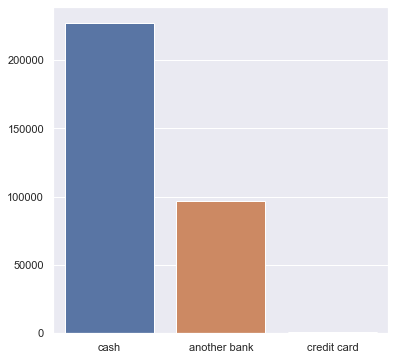

In [295]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(6, 6)})

x = count_operations.index.tolist()
y = count_operations.values.tolist()

sns.barplot(x=x, y=y)

In [296]:
print(f"Number of transactions with null operation: {trans.operation.isna().sum()}")

Number of transactions with null operation: 70761


Lots of transactions missing the operation value...

#### K-symbol

In [300]:
types_ksymbol = trans["k_symbol"].unique()
types_ksymbol

array([nan, 'household', 'payment for statement', 'old-age pension',
       'insurrance payment', 'interest credited',
       'sanction interest if negative balance'], dtype=object)

In [303]:
count_ksymbol = trans["k_symbol"].value_counts(dropna=False)
count_ksymbol

NaN                                      204309
interest credited                         70761
payment for statement                     58377
household                                 42839
old-age pension                           13502
insurrance payment                         6592
sanction interest if negative balance       305
Name: k_symbol, dtype: int64

The number of NaN transactions is too high to be considered as not important.

<AxesSubplot:>

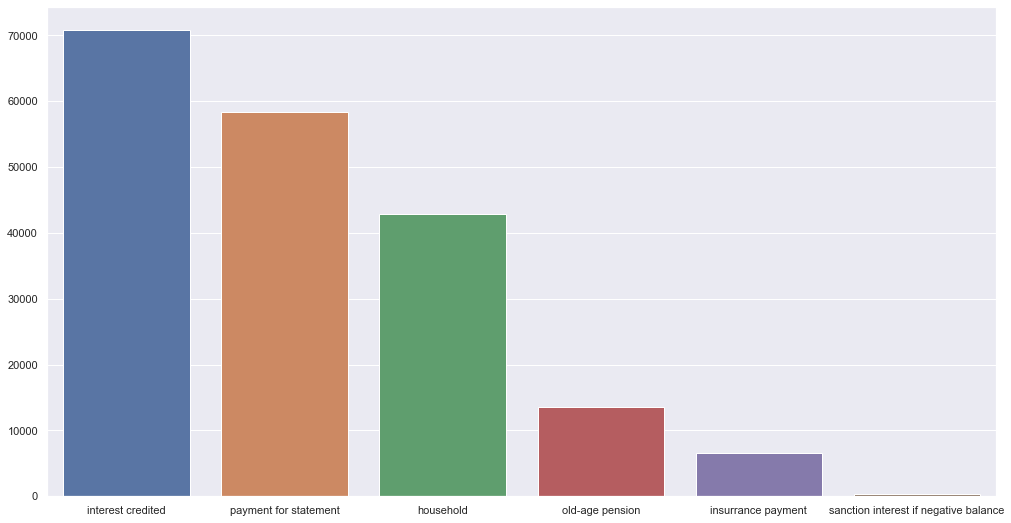

In [310]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(17, 9)})

x = count_ksymbol.index.tolist()
y = count_ksymbol.values.tolist()

sns.barplot(x=x, y=y)

#### Bank

In [311]:
types_bank = trans["bank"].unique()
types_bank

array([nan, 'AB', 'YZ', 'ST', 'QR', 'UV', 'OP', 'IJ', 'KL', 'EF', 'MN',
       'GH', 'CD', 'WX'], dtype=object)

In [316]:
counts_bank = trans["bank"].value_counts(dropna=False)
counts_bank

NaN    299443
ST       8114
GH       7886
EF       7878
AB       7666
UV       7618
OP       7595
IJ       7536
YZ       7471
QR       7413
KL       7397
WX       7033
CD       7009
MN       6626
Name: bank, dtype: int64

Once again, the number of NAN values might be too high to be discarded.

#### Others

**Years**

<AxesSubplot:>

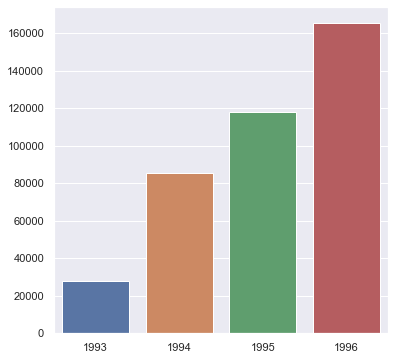

In [328]:
counts_year = trans['trans_year'].value_counts()
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(6, 6)})

x = counts_year.index.tolist()
y = counts_year.values.tolist()

sns.barplot(x=x, y=y)

Looks like an accurate distribution

**Months**

<AxesSubplot:>

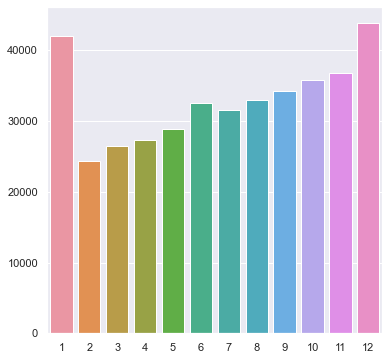

In [329]:
counts_months = trans['trans_month'].value_counts()
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(6, 6)})

x = counts_months.index.tolist()
y = counts_months.values.tolist()

sns.barplot(x=x, y=y)

More transactions in the months of January and December. Would assume these are the most commom months to pay the loan yearly installment

**Days**

<AxesSubplot:>

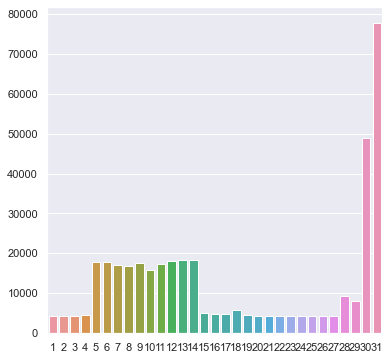

In [330]:
counts_days = trans['trans_day'].value_counts()
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(6, 6)})

x = counts_days.index.tolist()
y = counts_days.values.tolist()

sns.barplot(x=x, y=y)

Following the same logic, one would say that the last days of the month are the most commom to pay the loan installment

#### Balance 

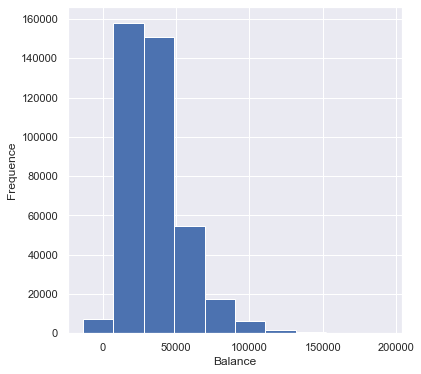

In [341]:
fig, ax = plt.subplots()
plt.hist(trans['balance'])
ax.set_xlabel("Balance")
ax.set_ylabel("Frequence")

plt.show()

In [339]:
average_balance = trans["balance"].mean()
print(f"The average balance after a transaction is {round(average_balance, 2)}€")

The average balance after a transaction is 35804.79€


#### Amount

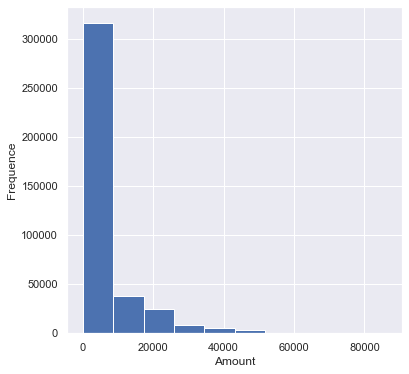

In [342]:
fig, ax = plt.subplots()
plt.hist(trans['amount'])
ax.set_xlabel("Amount")
ax.set_ylabel("Frequence")

plt.show()

In [344]:
average_trans_ammount = trans["amount"].mean()
print(f"The average amount of a transaction is {round(average_trans_ammount, 2)}€")

The average amount of a transaction is 5677.55€


#### Heatmap

<AxesSubplot:>

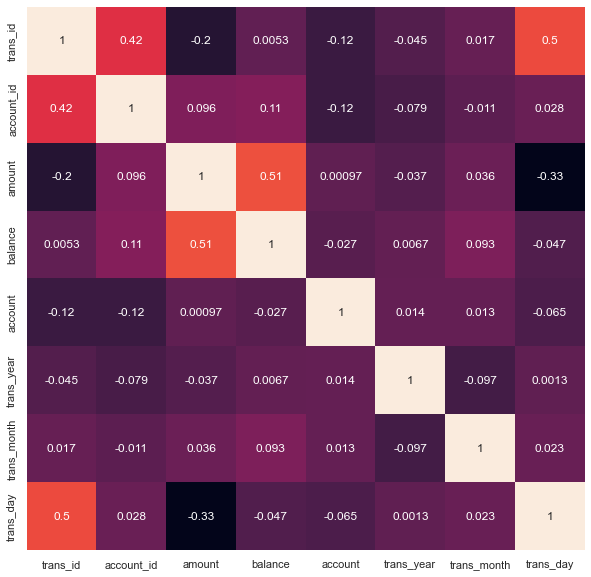

In [345]:
plt.figure(figsize=(10, 10))
sns.heatmap(trans.corr(), annot=True, cbar=False)

Obviously, there is correlation between the amount of a transaction and the balance after